# Tic Tac Toe

## Load Libaries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import MySQLdb
import tensorflow as tf
%matplotlib inline

## Load Data

In [2]:
# connect to database
db = MySQLdb.connect(host="localhost", user="root", password="", database="data_set")

In [3]:
cursor = db.cursor()

In [4]:
fields = ["field" + str(x) for x in range(9)]
outcome = ["won", "tied", "lost"]
decision = ["decision"]
columns = fields + outcome + decision

In [5]:
sql = "SELECT {} FROM tictactoe".format(", ".join(columns))
cursor.execute(sql)
records = cursor.fetchall()

In [6]:
df_orig = pd.DataFrame(records, columns=columns)

In [7]:
df_orig

field0  field1  field2  field3  field4  field5  field6  field7  field8  \
0           0       0       0       0       0       0       0       0       0   
1           0       0       0       0       0       0       0       0       0   
2           0       0       0       0       0       0       0       0       0   
3           0       0       0       0       0       0       0       0       0   
4           0       0       0       0       0       0       0       0       0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
15170       2       2       1       2       2       1       0       1       0   
15171       2       2       1       2       2       1       0       1       0   
15172       2       2       1       2       2       1       1       0       0   
15173       2       2       1       2       2       1       1       0       0   
15174       2       2       1       2       2       1       1       1       0   

        won  tied  lost  decision  
0      1253   427   890         0  
1       732   297   927         1  
2      1449   399   804         2  
3       771   305   995         3  
4      1893  1085  1050         4  
...     ...   ...   ...       ...  
15170     0     0     3         6  
15171     4     0     0         8  
15172     0     0     5         7  
15173     6     0     0         8  
15174    16     0     0         8  

[15175 rows x 13 columns]

In [8]:
df_orig.describe()

field0        field1        field2        field3        field4  \
count  15175.000000  15175.000000  15175.000000  15175.000000  15175.000000   
mean       0.839605      0.855420      0.835255      0.852850      0.831301   
std        0.852106      0.857087      0.851662      0.855687      0.848095   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        1.000000      1.000000      1.000000      1.000000      1.000000   
75%        2.000000      2.000000      2.000000      2.000000      2.000000   
max        2.000000      2.000000      2.000000      2.000000      2.000000   

             field5        field6        field7        field8           won  \
count  15175.000000  15175.000000  15175.000000  15175.000000  15175.000000   
mean       0.852323      0.840593      0.850610      0.844481      5.411466   
std        0.857520      0.852639      0.856146      0.853318     47.877513   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        1.000000      1.000000      1.000000      1.000000      1.000000   
75%        2.000000      2.000000      2.000000      2.000000      3.000000   
max        2.000000      2.000000      2.000000      2.000000   4140.000000   

               tied          lost      decision  
count  15175.000000  15175.000000  15175.000000  
mean       2.506359      4.509390      4.001120  
std       17.315419     29.540089      2.583354  
min        0.000000      0.000000      0.000000  
25%        0.000000      0.000000      2.000000  
50%        0.000000      1.000000      4.000000  
75%        1.000000      3.000000      6.000000  
max     1085.000000   1050.000000      8.000000

In [9]:
df_orig.keys()

Index(['field0', 'field1', 'field2', 'field3', 'field4', 'field5', 'field6',
       'field7', 'field8', 'won', 'tied', 'lost', 'decision'],
      dtype='object')

## Feature Engineering

In [10]:
df = df_orig.copy()

In [11]:
df["turn"] = (df[fields] != 0).sum(axis=1)

In [12]:
# df = pd.get_dummies(df, columns=["decision"])
for index, row in df.iterrows():
    df["field" + str(row["decision"])].iloc[index] = 1
df = df.drop("decision", axis=1)
df = pd.get_dummies(df, columns=fields, drop_first=True)

In [13]:
df["total_games"] = (df[outcome]).sum(axis=1)

In [14]:
df = df[df["total_games"] > 0]

In [15]:
df_temp = pd.DataFrame([], columns=list(df.columns) + ["salt"])

In [16]:
for _, row in df.iterrows():
    o_counts = {}
    for o in outcome:
        a = np.random.randint(0, 9, row[o])
        unique, counts = np.unique(a, return_counts=True)
        o_counts[o] = dict(zip(unique, counts))
    for a in range(9):
        row["salt"] = a
        for o in outcome:
            try:
                row[o] = o_counts[o][a]
            except KeyError:
                row[o] = 0
        df_temp = df_temp.append(row, ignore_index=True)

In [17]:
df_final = df_temp.copy()

In [18]:
df_final = df_final.apply(pd.to_numeric, axis=0)

In [19]:
df_final = df_final[df_final[outcome].sum(axis=1) != 0]
df_final["target"] = (3 * df_final["won"] - 5 * df_final["lost"])/(3 * df_final["won"] + df_final["tied"] + 5 * df_final["lost"])

In [20]:
df_final["target"].describe()

count    59178.000000
mean         0.023158
std          0.862899
min         -1.000000
25%         -1.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: target, dtype: float64

In [21]:
df_final

won  tied  lost  turn  field0_1  field0_2  field1_1  field1_2  \
0       146    47   110     0         1         0         0         0   
1       125    50   104     0         1         0         0         0   
2       144    53    93     0         1         0         0         0   
3       123    43    88     0         1         0         0         0   
4       149    55   103     0         1         0         0         0   
...     ...   ...   ...   ...       ...       ...       ...       ...   
133933    1     0     0     8         0         1         0         1   
133934    2     0     0     8         0         1         0         1   
133935    2     0     0     8         0         1         0         1   
133936    2     0     0     8         0         1         0         1   
133937    2     0     0     8         0         1         0         1   

        field2_1  field2_2  ...  field5_2  field6_1  field6_2  field7_1  \
0              0         0  ...         0         0         0         0   
1              0         0  ...         0         0         0         0   
2              0         0  ...         0         0         0         0   
3              0         0  ...         0         0         0         0   
4              0         0  ...         0         0         0         0   
...          ...       ...  ...       ...       ...       ...       ...   
133933         1         0  ...         0         1         0         1   
133934         1         0  ...         0         1         0         1   
133935         1         0  ...         0         1         0         1   
133936         1         0  ...         0         1         0         1   
133937         1         0  ...         0         1         0         1   

        field7_2  field8_1  field8_2  total_games  salt    target  
0              0         0         0         2570     0 -0.108213  
1              0         0         0         2570     1 -0.153439  
2              0         0         0         2570     2 -0.034737  
3              0         0         0         2570     3 -0.083333  
4              0         0         0         2570     4 -0.066863  
...          ...       ...       ...          ...   ...       ...  
133933         0         1         0           16     4  1.000000  
133934         0         1         0           16     5  1.000000  
133935         0         1         0           16     6  1.000000  
133936         0         1         0           16     7  1.000000  
133937         0         1         0           16     8  1.000000  

[59178 rows x 25 columns]

In [22]:
df_final = df_final.drop(["total_games"] + outcome, axis=1)

## Training

In [23]:
targets = "target"
X_train = df_final.drop(targets, axis=1)
Y_train = df_final[targets]

In [24]:
X_train.shape, Y_train.shape

((59178, 20), (59178,))

In [33]:
import tensorflow.keras
from keras.models import Sequential 
from keras.layers import Dense
from keras import regularizers
from keras import optimizers



ann = Sequential()
ann.add(Dense(50, input_dim = X_train.shape[1], activation = 'relu'))
ann.add(Dense(80, activation='relu',  kernel_regularizer=regularizers.l2(0.15)))
ann.add(Dense(50, activation='relu',  kernel_regularizer=regularizers.l2(0.2)))
ann.add(Dense(30, activation='relu',  kernel_regularizer=regularizers.l2(0.2)))
ann.add(Dense(1, activation='linear'))


ann.compile(loss='mean_squared_error', optimizer='adam')
epochs_hist = ann.fit(X_train, Y_train, epochs=20, batch_size=50, validation_split=0.2)

Train on 47342 samples, validate on 11836 samples
Epoch 1/100
47342/47342 [==============================] - 3s 70us/step - loss: 1.9381 - val_loss: 0.7111
Epoch 2/100
47342/47342 [==============================] - 3s 60us/step - loss: 0.6546 - val_loss: 0.7124
Epoch 3/100
47342/47342 [==============================] - 3s 60us/step - loss: 0.6324 - val_loss: 0.7367
Epoch 4/100
47342/47342 [==============================] - 3s 62us/step - loss: 0.6095 - val_loss: 0.7148
Epoch 5/100
47342/47342 [==============================] - 3s 54us/step - loss: 0.5890 - val_loss: 0.6878
Epoch 6/100
47342/47342 [==============================] - 3s 59us/step - loss: 0.5697 - val_loss: 0.6688
Epoch 7/100
47342/47342 [==============================] - 3s 66us/step - loss: 0.5480 - val_loss: 0.6379
Epoch 8/100
47342/47342 [==============================] - 3s 60us/step - loss: 0.5299 - val_loss: 0.6352
Epoch 9/100
47342/47342 [==============================] - 3s 55us/step - loss: 0.5124 - val_loss: 0.6

47342/47342 [==============================] - 2s 50us/step - loss: 0.3648 - val_loss: 0.3797
Epoch 78/100
47342/47342 [==============================] - 3s 65us/step - loss: 0.3639 - val_loss: 0.3993
Epoch 79/100
47342/47342 [==============================] - 3s 53us/step - loss: 0.3633 - val_loss: 0.3822
Epoch 80/100
47342/47342 [==============================] - 3s 53us/step - loss: 0.3632 - val_loss: 0.4031
Epoch 81/100
47342/47342 [==============================] - 2s 48us/step - loss: 0.3636 - val_loss: 0.4689
Epoch 82/100
47342/47342 [==============================] - 2s 52us/step - loss: 0.3641 - val_loss: 0.3881
Epoch 83/100
47342/47342 [==============================] - 3s 54us/step - loss: 0.3617 - val_loss: 0.3710
Epoch 84/100
47342/47342 [==============================] - 2s 51us/step - loss: 0.3631 - val_loss: 0.3832
Epoch 85/100
47342/47342 [==============================] - 3s 71us/step - loss: 0.3618 - val_loss: 0.3862
Epoch 86/100
47342/47342 [========================

In [26]:
ann.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_2 (Dense)              (None, 80)                2480      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 31        
Total params: 5,571
Trainable params: 5,571
Non-trainable params: 0
_________________________________________________________________


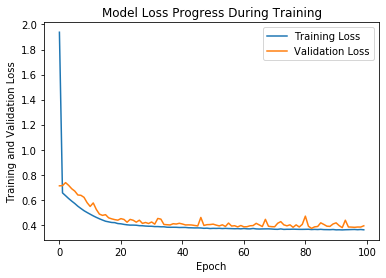

In [34]:
plt.plot(epochs_hist.history['loss'])
plt.plot(epochs_hist.history['val_loss'])
plt.title('Model Loss Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training and Validation Loss')
plt.legend(['Training Loss', 'Validation Loss'])

## Save Model

In [35]:
# ann.save("tictactoe.h5")

## Evaluation

In [29]:
def evaluate(fields):
    data = [[0] * 9, [1] * 9, [2] * 9, fields]

    columns = ["field" + str(x) for x in range(9)]
    sample = pd.DataFrame(np.array(data).reshape(4, 9), columns=columns)

    sample["turn"] = (sample[columns] != 0).sum(axis=1)
    sample = pd.get_dummies(sample, columns=columns, drop_first=True)
    sample = sample.drop([0, 1, 2])
        
    best_index = 0
    best_value = -np.inf
    for index, field in enumerate(fields):
        if fields[index] == 0:
            sample_ = sample.copy()
            sample_["field" + str(index) + "_1"] = 1
    
            sample_["salt"] = np.random.randint(0, 8, 1)
            
            value = ann.predict(sample_)
            print(value)
            
            if value > best_value:
                best_index = index
                best_value = value

    return best_index

In [30]:
evaluate([0, 0, 0, 0, 0, 0, 0, 0, 0])

[[-0.07086737]]
[[-0.23828988]]
[[-0.11687604]]
[[-0.15214498]]
[[0.21839286]]
[[0.0032316]]
[[-0.06821511]]
[[-0.14357181]]
[[0.09823844]]


4